In [1]:
# Importing Library 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
alnz = pd.read_csv('data/allianz.csv')
depost = pd.read_csv('data/deutsche-post.csv')
detel = pd.read_csv('data/deutsche-telekom.csv')
merckg = pd.read_csv('data/merck-kgaa.csv')
siem = pd.read_csv('data/siemens.csv')

In [3]:
#Drop unnecessary data
alnz.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
depost.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
detel.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
merckg.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
siem.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)

In [4]:
# Change Dtype of Date column
alnz['Date']=pd.to_datetime(alnz['Date'])
depost['Date']=pd.to_datetime(depost['Date'])
detel['Date']=pd.to_datetime(detel['Date'])
merckg['Date']=pd.to_datetime(merckg['Date'])
siem['Date']=pd.to_datetime(siem['Date'])

In [5]:
#Set Index as Date
alnz.set_index('Date',inplace=True)
depost.set_index('Date',inplace=True)
detel.set_index('Date',inplace=True)
merckg.set_index('Date',inplace=True)
siem.set_index('Date',inplace=True)

In [6]:
# Backup data
siem_base = siem.copy()
detel_base = detel.copy()
alnz_base = alnz.copy()
merckg_base = merckg.copy()
depost_base = depost.copy()

# Allianz 1 Features

In [7]:
#Set next day value as target 
alnz['Target'] = alnz.Close.shift(-1)
alnz.dropna(inplace=True)
alnz

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,45.519119,9.154412,1.292624,45.657921
2010-01-05,45.657921,9.154412,1.292624,46.012665
2010-01-06,46.012665,9.154412,1.292624,45.483131
2010-01-07,45.483131,9.154412,1.292624,45.236355
2010-01-08,45.236355,9.154412,1.292624,44.727394
...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997
2023-06-26,209.199997,10.264393,1.461468,211.300003
2023-06-27,211.300003,10.264393,1.461468,211.649994


In [8]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-10-07' # End date of training set
test_start_date = '2020-10-08' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [9]:
#split train and test data
alnz_train = alnz.loc[:end_date]
alnz_test = alnz.loc[test_start_date:]

In [10]:
# Reconcile length of data set and subsets
alnz.shape[0] == alnz_train.shape[0] + alnz_test.shape[0]

True

In [11]:
#set features and target
alnz_X_train = alnz_train['Close']
alnz_y_train = alnz_train['Target']
alnz_X_test = alnz_test['Close']
alnz_y_test = alnz_test['Target']

# Model

In [12]:
# Set of parameters
parameters = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [6, 8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

In [13]:
# Setting up RandomizedSearchCV
model1 = xgb.XGBRegressor(objective='reg:squarederror', verbose=False)
random_search1 = RandomizedSearchCV(estimator=model1,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search1.fit(alnz_X_train, alnz_y_train)
print(f'Best params: {random_search1.best_params_}')
print(f'Best validation score = {random_search1.best_score_}')

Best params: {'random_state': 42, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.001}
Best validation score = -53.39441328418775


In [14]:
#fit the model
model1 = xgb.XGBRegressor(**random_search1.best_params_, objective='reg:squarederror')
model1.fit(alnz_X_train, alnz_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
#predicted data 
alnz_test['Predicted_Close'] = model1.predict(alnz_X_test)

In [16]:
#show the result
alnz_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,144.441971,9.953418,0.874770,144.838226,144.070068
2020-10-09,144.838226,9.953418,0.874770,146.302643,144.756256
2020-10-12,146.302643,9.953418,0.874770,143.442734,145.756409
2020-10-13,143.442734,9.953418,0.874770,143.873459,144.039581
2020-10-14,143.873459,9.953418,0.874770,139.755890,143.562073
...,...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997,185.911041
2023-06-26,209.199997,10.264393,1.461468,211.300003,185.911041
2023-06-27,211.300003,10.264393,1.461468,211.649994,185.911041


In [17]:
#checking mse and rmse 
alnz_mse = mean_squared_error(alnz_y_test, alnz_test['Predicted_Close'])
alnz_rmse = math.sqrt(alnz_mse)
alnz_mape = np.mean(np.abs(alnz_test['Predicted_Close'] - alnz_y_test)/np.abs(alnz_y_test))

print(f'Root Mean Squared Error (RMSE): {alnz_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {alnz_mape}')

Root Mean Squared Error (RMSE): 10.689326530542168
Mean Absolute Percentage Error (MAPE): 0.036261719064730885


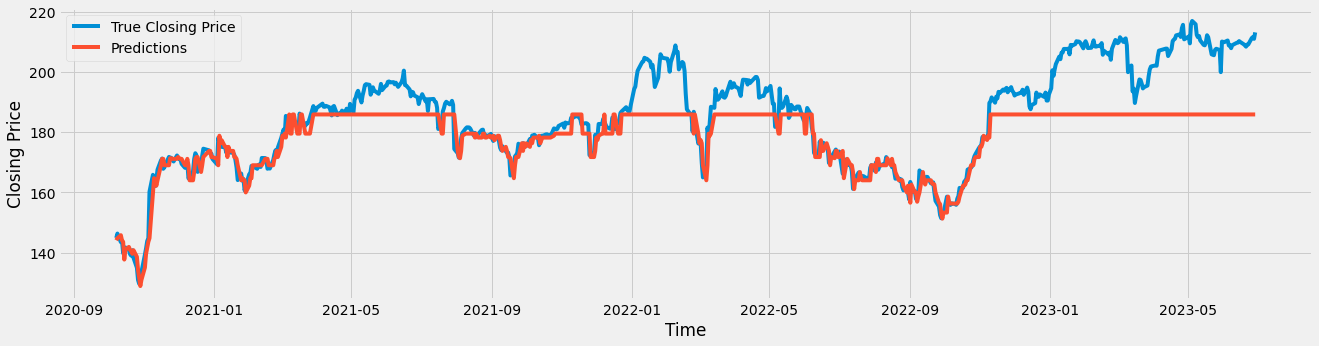

In [18]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(alnz_test['Target'], label = 'True Closing Price')
plt.plot(alnz_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [19]:
# Create a dataframe that has same index as allianz dataframe
result1 = pd.DataFrame(index=alnz_base.index)
# Extract actual data from SIE
tem1 = alnz_base['Close'].tolist()[:len(alnz_base)-695]
# Extract forecasted date from above result
tem2 = alnz_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [20]:
#added predicted data with real data

result1

,ALV,Forecasted
Date,,
2010-01-04,45.519119,N
2010-01-05,45.657921,N
2010-01-06,46.012665,N
2010-01-07,45.483131,N
2010-01-08,45.236355,N
...,...,...
2023-06-26,185.911041,Y
2023-06-27,185.911041,Y
2023-06-28,185.911041,Y


# Deutsche Post 1 Features

In [21]:
#Set next day value as target 
depost['Target'] = depost.Close.shift(-1)
depost.dropna(inplace=True)
depost

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,13.980000,25.443396,1.970697,14.000
2010-01-05,14.000000,25.443396,1.970697,14.155
2010-01-06,14.155000,25.443396,1.970697,14.125
2010-01-07,14.125000,25.443396,1.970697,14.460
2010-01-08,14.460000,25.443396,1.970697,14.380
...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000
2023-06-26,43.000000,10.613300,1.588590,43.500
2023-06-27,43.500000,10.613300,1.588590,44.305


In [22]:
#split train and test data
depost_train = depost.loc[:end_date]
depost_test = depost.loc[test_start_date:]

In [23]:
# Reconcile length of data set and subsets
depost.shape[0] == depost_train.shape[0] + depost_test.shape[0]

True

In [24]:
#set features and target
depost_X_train = depost_train['Close']
depost_y_train = depost_train['Target']
depost_X_test = depost_test['Close']
depost_y_test = depost_test['Target']

In [25]:
# Setting up RandomizedSearchCV
model2 = xgb.XGBRegressor(objective='reg:squarederror', verbose=False)
random_search2 = RandomizedSearchCV(estimator=model2,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search2.fit(depost_X_train, depost_y_train)
print(f'Best params: {random_search2.best_params_}')
print(f'Best validation score = {random_search2.best_score_}')

Best params: {'random_state': 42, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.001}
Best validation score = -1.0401723771215674


In [26]:
#xgb regressor
model2 = xgb.XGBRegressor(**random_search2.best_params_, objective='reg:squarederror')
model2.fit(depost_X_train, depost_y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
#predicted data 
depost_test['Predicted_Close'] = model2.predict(depost_X_test)

In [28]:
#checking predicted data
depost_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,40.970001,18.933283,3.600308,41.279999,40.532909
2020-10-09,41.279999,18.933283,3.600308,41.299999,40.532909
2020-10-12,41.299999,18.933283,3.600308,41.470001,40.532909
2020-10-13,41.470001,18.933283,3.600308,41.950001,40.532909
2020-10-14,41.950001,18.933283,3.600308,40.709999,40.532909
...,...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000000,40.532909
2023-06-26,43.000000,10.613300,1.588590,43.500000,40.532909
2023-06-27,43.500000,10.613300,1.588590,44.305000,40.532909


In [29]:
#checking mse and rmse 
depost_mse = mean_squared_error(depost_y_test, depost_test['Predicted_Close'])
depost_rmse = math.sqrt(depost_mse)
depost_mape = np.mean(np.abs(depost_test['Predicted_Close'] - depost_y_test)/np.abs(depost_y_test))

print(f'Root Mean Squared Error (RMSE): {depost_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {depost_mape}')

Root Mean Squared Error (RMSE): 8.547241460770078
Mean Absolute Percentage Error (MAPE): 0.10465189493817358


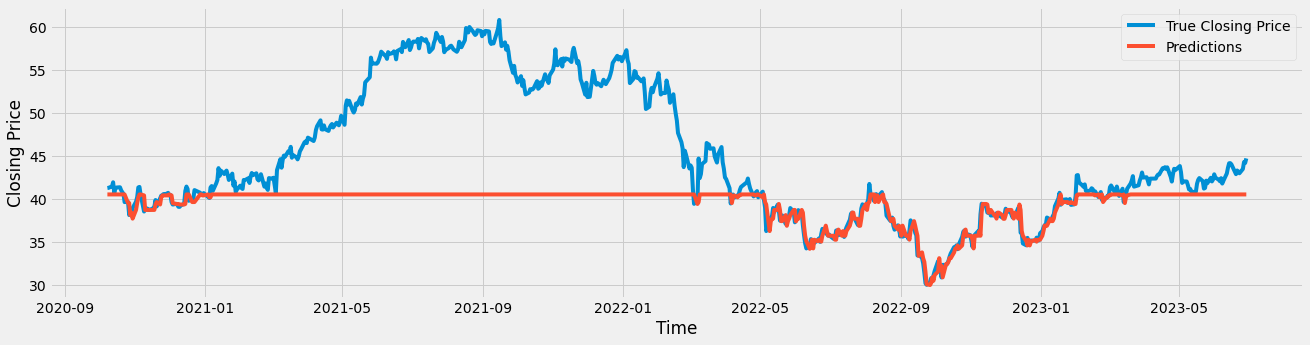

In [30]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(depost_test['Target'], label = 'True Closing Price')
plt.plot(depost_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [31]:
# Extract actual data from depost
tem1 = depost_base['Close'].tolist()[:len(depost_base)+6-695]
# Extract forecasted date from above result
tem2 = depost_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [32]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL
Date,,,
2010-01-04,45.519119,N,13.980000
2010-01-05,45.657921,N,14.000000
2010-01-06,46.012665,N,14.155000
2010-01-07,45.483131,N,14.125000
2010-01-08,45.236355,N,14.460000
...,...,...,...
2023-06-26,185.911041,Y,40.532909
2023-06-27,185.911041,Y,40.532909
2023-06-28,185.911041,Y,40.532909


# Deutsche Telekom 1 Features

In [33]:
#Set next day value as target 
detel['Target'] = detel.Close.shift(-1)
detel.dropna(inplace=True)
detel

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,4.953136,128.625000,1.070129,4.911083
2010-01-05,4.911083,128.625000,1.070129,4.789590
2010-01-06,4.789590,128.625000,1.070129,4.698472
2010-01-07,4.698472,128.625000,1.070129,4.724171
2010-01-08,4.724171,128.625000,1.070129,4.756881
...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999
2023-06-26,19.695999,5.658228,1.057418,19.906000
2023-06-27,19.906000,5.658228,1.057418,20.030001


In [34]:
#split train and test data
detel_train = detel.loc[:end_date]
detel_test = detel.loc[test_start_date:]

In [35]:
# Reconcile length of data set and subsets
detel.shape[0] == detel_train.shape[0] + detel_test.shape[0]

True

In [36]:
#set features and target
detel_X_train = detel_train['Close']
detel_y_train = detel_train['Target']
detel_X_test = detel_test['Close']
detel_y_test = detel_test['Target']

In [37]:
# Setting up RandomizedSearchCV
model3 = xgb.XGBRegressor(objective='reg:squarederror', verbose=False)
random_search3 = RandomizedSearchCV(estimator=model3,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search3.fit(detel_X_train, detel_y_train)
print(f'Best params: {random_search3.best_params_}')
print(f'Best validation score = {random_search3.best_score_}')

Best params: {'random_state': 42, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.001}
Best validation score = -0.06183547364960769


In [38]:
#xgb regressor
model3 = xgb.XGBRegressor(**random_search3.best_params_, objective='reg:squarederror')
model3.fit(detel_X_train, detel_y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
#predicted data 
detel_test['Predicted_Close'] = model3.predict(detel_X_test)

In [40]:
#showing predicted data
detel_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,13.030954,21.651515,0.940896,12.981357,13.034712
2020-10-09,12.981357,21.651515,0.940896,13.067026,13.034712
2020-10-12,13.067026,21.651515,0.940896,13.107607,13.139820
2020-10-13,13.107607,21.651515,0.940896,13.053500,13.139820
2020-10-14,13.053500,21.651515,0.940896,12.643183,13.139820
...,...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999,13.762123
2023-06-26,19.695999,5.658228,1.057418,19.906000,13.762123
2023-06-27,19.906000,5.658228,1.057418,20.030001,13.762123


In [41]:
#checking mse and rmse 
detel_mse = mean_squared_error(detel_y_test, detel_test['Predicted_Close'])
detel_rmse = math.sqrt(detel_mse)
detel_mape = np.mean(np.abs(detel_test['Predicted_Close'] - detel_y_test)/np.abs(detel_y_test))

print(f'Root Mean Squared Error (RMSE): {detel_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {detel_mape}')

Root Mean Squared Error (RMSE): 3.913217781191653
Mean Absolute Percentage Error (MAPE): 0.17398933598339092


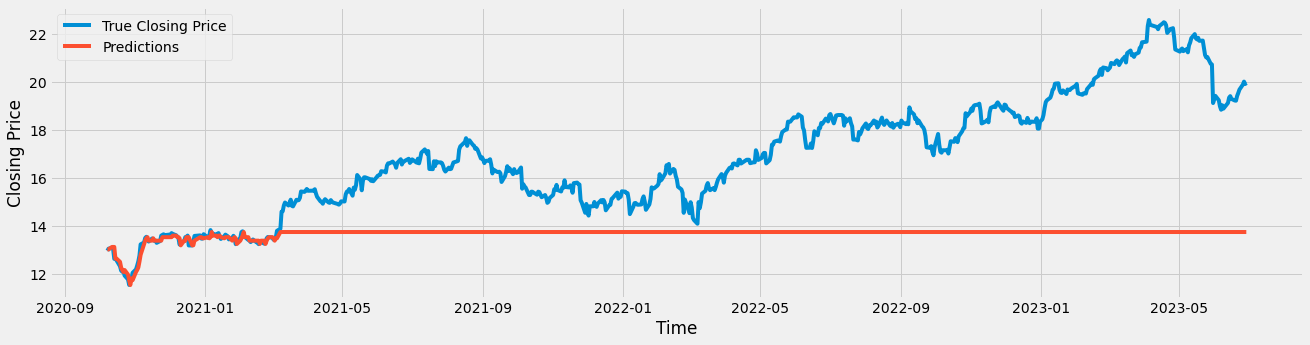

In [42]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(detel_test['Target'], label = 'True Closing Price')
plt.plot(detel_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [43]:
# Extract actual data from deutsche-telekom
tem1 = detel_base['Close'].tolist()[:len(detel_base)-695]
# Extract forecasted date from above result
tem2 = detel_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [44]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE
Date,,,,
2010-01-04,45.519119,N,13.980000,4.953136
2010-01-05,45.657921,N,14.000000,4.911083
2010-01-06,46.012665,N,14.155000,4.789590
2010-01-07,45.483131,N,14.125000,4.698472
2010-01-08,45.236355,N,14.460000,4.724171
...,...,...,...,...
2023-06-26,185.911041,Y,40.532909,13.762123
2023-06-27,185.911041,Y,40.532909,13.762123
2023-06-28,185.911041,Y,40.532909,13.762123


# Merck KGaA 1 Features

In [45]:
#Set next day value as target 
merckg['Target'] = merckg.Close.shift(-1)
merckg.dropna(inplace=True)
merckg

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,26.576839,38.785717,1.488928,26.381214
2010-01-05,26.381214,38.785717,1.488928,26.364910
2010-01-06,26.364910,38.785717,1.488928,26.919188
2010-01-07,26.919188,38.785717,1.488928,26.646120
2010-01-08,26.646120,38.785717,1.488928,26.739857
...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006
2023-06-26,152.600006,23.026846,3.013593,147.199997
2023-06-27,147.199997,23.026846,3.013593,150.500000


In [46]:
#split train and test data
merckg_train = merckg.loc[:end_date]
merckg_test = merckg.loc[test_start_date:]

In [47]:
# Reconcile length of data set and subsets
merckg.shape[0] == merckg_train.shape[0] + merckg_test.shape[0]

True

In [48]:
#set features and target
merckg_X_train = merckg_train['Close']
merckg_y_train = merckg_train['Target']
merckg_X_test = merckg_test['Close']
merckg_y_test = merckg_test['Target']

In [49]:
# Setting up RandomizedSearchCV
model4 = xgb.XGBRegressor(objective='reg:squarederror', verbose=False)
random_search4 = RandomizedSearchCV(estimator=model4,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search4.fit(merckg_X_train, merckg_y_train)
print(f'Best params: {random_search4.best_params_}')
print(f'Best validation score = {random_search4.best_score_}')

Best params: {'random_state': 42, 'n_estimators': 400, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.001}
Best validation score = -29.13397601939033


In [50]:
#xgb regressor
model4 = xgb.XGBRegressor(**random_search4.best_params_, objective='reg:squarederror')
model4.fit(merckg_X_train, merckg_y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
#predicted data 
merckg_test['Predicted_Close'] = model4.predict(merckg_X_test)

In [52]:
merckg_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,126.032745,28.965117,3.009257,126.661209,122.272835
2020-10-09,126.661209,28.965117,3.009257,126.661209,122.272835
2020-10-12,126.661209,28.965117,3.009257,126.226120,122.272835
2020-10-13,126.226120,28.965117,3.009257,124.098984,122.272835
2020-10-14,124.098984,28.965117,3.009257,119.699684,122.272835
...,...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006,122.272835
2023-06-26,152.600006,23.026846,3.013593,147.199997,122.272835
2023-06-27,147.199997,23.026846,3.013593,150.500000,122.272835


In [53]:
#checking mse and rmse 
merckg_mse = mean_squared_error(merckg_y_test, merckg_test['Predicted_Close'])
merckg_rmse = math.sqrt(merckg_mse)
merckg_mape = np.mean(np.abs(merckg_test['Predicted_Close'] - merckg_y_test)/np.abs(merckg_y_test))

print(f'Root Mean Squared Error (RMSE): {merckg_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {merckg_mape}')

Root Mean Squared Error (RMSE): 50.76414499250016
Mean Absolute Percentage Error (MAPE): 0.2544408856622091


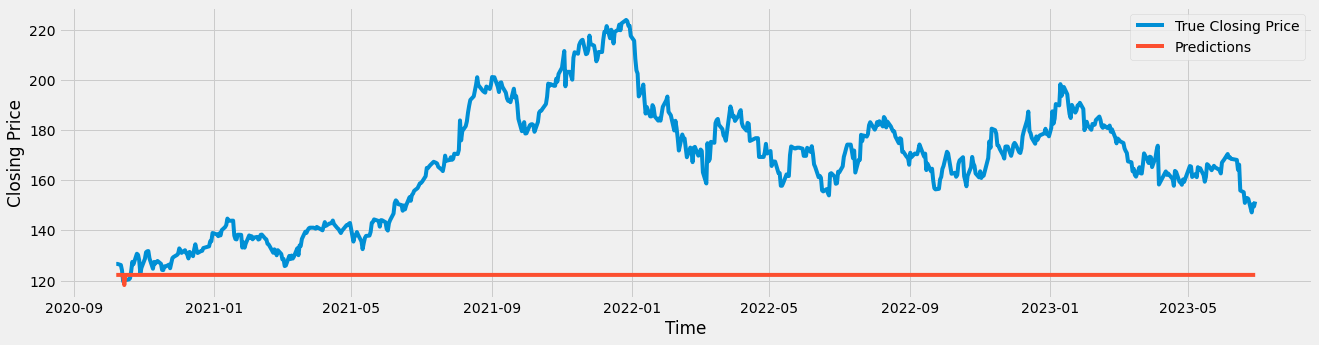

In [54]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(merckg_test['Target'], label = 'True Closing Price')
plt.plot(merckg_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [55]:
# Extract actual data from merck-kgaa
tem1 = merckg_base['Close'].tolist()[:len(merckg_base)-695]
# Extract forecasted date from above result
tem2 = merckg_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [56]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE,MRK
Date,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839
2010-01-05,45.657921,N,14.000000,4.911083,26.381214
2010-01-06,46.012665,N,14.155000,4.789590,26.364910
2010-01-07,45.483131,N,14.125000,4.698472,26.919188
2010-01-08,45.236355,N,14.460000,4.724171,26.646120
...,...,...,...,...,...
2023-06-26,185.911041,Y,40.532909,13.762123,122.272835
2023-06-27,185.911041,Y,40.532909,13.762123,122.272835
2023-06-28,185.911041,Y,40.532909,13.762123,122.272835


# Siemens 1 Features

In [57]:
#Set next day value as target 
siem['Target'] = siem.Close.shift(-1)
siem.dropna(inplace=True)
siem

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,39.892437,21.092000,1.938798,39.916805
2010-01-05,39.916805,21.092000,1.938798,40.063042
2010-01-06,40.063042,21.092000,1.938798,40.538315
2010-01-07,40.538315,21.092000,1.938798,40.794235
2010-01-08,40.794235,21.092000,1.938798,40.897816
...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996
2023-06-26,155.479996,19.691292,1.998793,157.559998
2023-06-27,157.559998,19.691292,1.998793,152.720001


In [58]:
#split train and test data
siem_train = siem.loc[:end_date]
siem_test = siem.loc[test_start_date:]

In [59]:
# Reconcile length of data set and subsets
siem.shape[0] == siem_train.shape[0] + siem_test.shape[0]

True

In [60]:
#set features and target
siem_X_train = siem_train['Close']
siem_y_train = siem_train['Target']
siem_X_test = siem_test['Close']
siem_y_test = siem_test['Target']

In [61]:
# Setting up RandomizedSearchCV
model5 = xgb.XGBRegressor(objective='reg:squarederror', verbose=False)
random_search5 = RandomizedSearchCV(estimator=model5,
                                    param_distributions=parameters,
                                    n_iter=50,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    random_state=42)
random_search5.fit(siem_X_train, siem_y_train)
print(f'Best params: {random_search5.best_params_}')
print(f'Best validation score = {random_search5.best_score_}')

Best params: {'random_state': 42, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.02}
Best validation score = -1.5935896796467897


In [62]:
#xgb regressor
model5 = xgb.XGBRegressor(**random_search5.best_params_, objective='reg:squarederror')
model5.fit(siem_X_train, siem_y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.02, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [63]:
#predicted data 
siem_test['Predicted_Close'] = model5.predict(siem_X_test)

In [64]:
#checking predicted data
siem_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,102.015335,21.575999,2.165320,102.678017,102.095337
2020-10-09,102.678017,21.575999,2.165320,103.487961,102.502693
2020-10-12,103.487961,21.575999,2.165320,102.383484,103.434082
2020-10-13,102.383484,21.575999,2.165320,103.451141,101.449753
2020-10-14,103.451141,21.575999,2.165320,100.634758,103.434082
...,...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996,109.097946
2023-06-26,155.479996,19.691292,1.998793,157.559998,109.097946
2023-06-27,157.559998,19.691292,1.998793,152.720001,109.097946


In [65]:
#added predicted data with real data
siem_mse = mean_squared_error(siem_y_test, siem_test['Predicted_Close'])
siem_rmse = math.sqrt(siem_mse)
siem_mape = np.mean(np.abs(siem_test['Predicted_Close'] - siem_y_test)/np.abs(siem_y_test))

print(f'Root Mean Squared Error (RMSE): {siem_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {siem_mape}')

Root Mean Squared Error (RMSE): 22.931702119036753
Mean Absolute Percentage Error (MAPE): 0.133814815365095


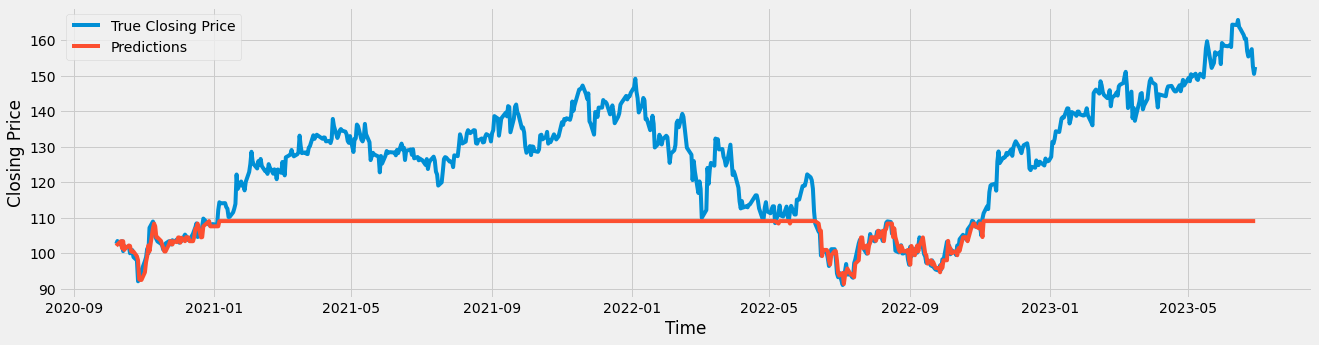

In [66]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(siem_test['Target'], label = 'True Closing Price')
plt.plot(siem_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [67]:
# Extract actual data from siem
tem1 = siem_base['Close'].tolist()[:len(siem_base)-695]
# Extract forecasted date from above result
tem2 = siem_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3

In [68]:
#merged all predicted data
result1

,ALV,Forecasted,DHL,DTE,MRK,SIE
Date,,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839,39.892437
2010-01-05,45.657921,N,14.000000,4.911083,26.381214,39.916805
2010-01-06,46.012665,N,14.155000,4.789590,26.364910,40.063042
2010-01-07,45.483131,N,14.125000,4.698472,26.919188,40.538315
2010-01-08,45.236355,N,14.460000,4.724171,26.646120,40.794235
...,...,...,...,...,...,...
2023-06-26,185.911041,Y,40.532909,13.762123,122.272835,109.097946
2023-06-27,185.911041,Y,40.532909,13.762123,122.272835,109.097946
2023-06-28,185.911041,Y,40.532909,13.762123,122.272835,109.097946


In [69]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,109.097946,13.762123,185.911041,122.272835,40.532909,Y
2023-06-27,109.097946,13.762123,185.911041,122.272835,40.532909,Y
2023-06-28,109.097946,13.762123,185.911041,122.272835,40.532909,Y


In [70]:
#checking the final data
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,109.097946,13.762123,185.911041,122.272835,40.532909,Y
2023-06-27,109.097946,13.762123,185.911041,122.272835,40.532909,Y
2023-06-28,109.097946,13.762123,185.911041,122.272835,40.532909,Y


In [71]:
#save forecased data in csv file
result.to_csv('XGBoost_1 feature.csv', index=True)

# Bibliography

-	Li, A. (2024). _simplestocks/app.py at main · alvinscode/simplestocks._ [online] GitHub. Available at: https://github.com/alvinscode/simplestocks/blob/main/app.py [Accessed 26 Feb. 2024].
-	Tan, J.W. (2019). _XGBoost_stock_prediction/XGBoost_stock_prediction.ipynb at master · jiewwantan/XGBoost_stock_prediction._ [online] GitHub. Available at: https://github.com/jiewwantan/XGBoost_stock_prediction/blob/master/XGBoost_stock_prediction.ipynb [Accessed 26 Feb. 2024].